In [1]:
import importlib
import shiftNMF
importlib.reload(shiftNMF)
from shiftNMF import ShiftNMF
from nnls_l1 import nnls
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from helpers.generators import *
from helpers.data import X_WINE, PPM_WINE
import Hardmodel_single_peaks
importlib.reload(Hardmodel_single_peaks)
from Hardmodel_single_peaks import Single_Model
import Hardmodel
importlib.reload(Hardmodel)
from Hardmodel import Hard_Model
import scipy
from scipy.signal import find_peaks
import itertools
import torch

import helpers.fit_functions 
importlib.reload(helpers.fit_functions)
from helpers.fit_functions import *

# shiftNMF

[5.99978451 5.99915313 5.99852176 ... 0.50114961 0.50051823 0.49988686]
3.758407321767532
3.474289087241136


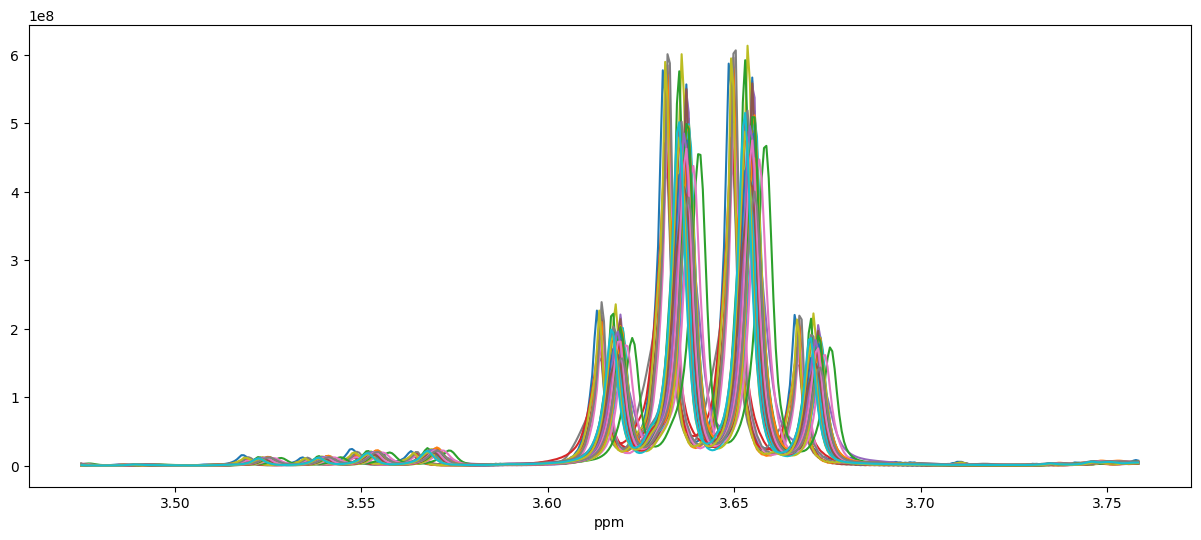

In [2]:
# 3.5-3.7
si = 3550
ei = 4000
#3.5-3.6
# si = 3800
# ei = 4000
#

print(PPM_WINE)
X = X_WINE[:,si:ei]
print(PPM_WINE[si])
print(PPM_WINE[ei])
ppm = PPM_WINE[si:ei]
plt.figure(figsize=(15,6))
plt.plot(ppm,X.T)
plt.xlabel("ppm")
plt.show()

epoch: 1000, Loss: 0.015025890423381238, Tau: 1194.6928475553873


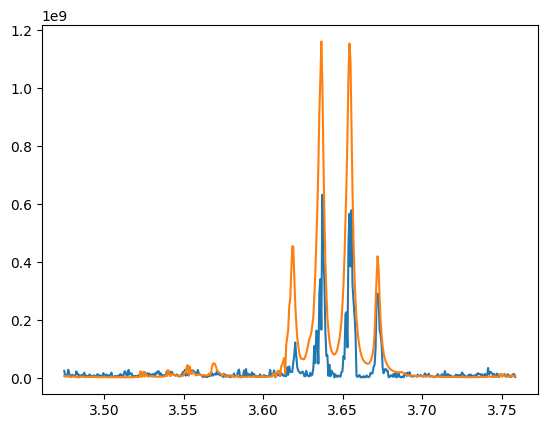

In [3]:
torch.manual_seed(42)
nmf = ShiftNMF(X, 2, lr=0.1, alpha=1e-6, patience=30, min_imp=-10000)
W_est, H_est, tau_est = nmf.fit(verbose=1, max_iter=1000, tau_iter=0, Lambda=0.000)
plt.plot(ppm,H_est.T)
plt.show()


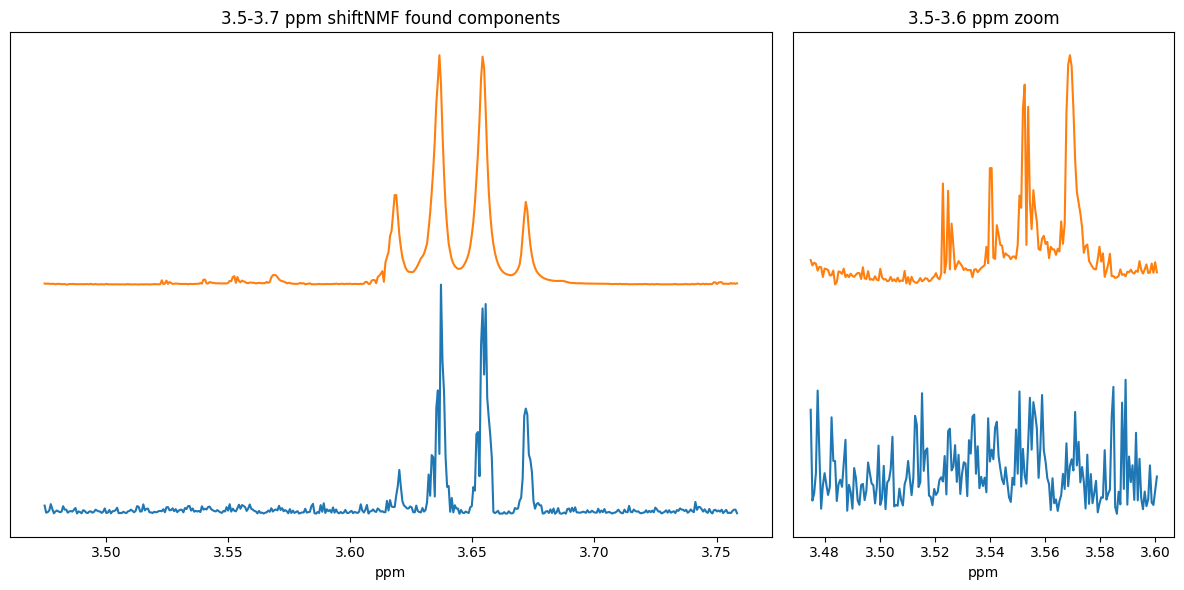

In [5]:
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

fig = plt.figure(figsize=(12, 6))
H_scaled = np.zeros_like(H_est)
for i, vec in enumerate(H_est):
    H_scaled[i] = vec/max(vec)

# Plot H and H_est
ax1 = plt.subplot(gs[0])
plotSpaced(ax1, ppm, H_scaled.T)
ax1.set_title('3.5-3.7 ppm shiftNMF found components')
ax1.set_xlabel("ppm")

ax2 = plt.subplot(gs[1])
ax2.set_title('3.5-3.6 ppm zoom')
plotSpaced(ax2, ppm[250:],H_est[:,250:].T)
ax2.set_xlabel("ppm")


# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# Set tight layout
plt.tight_layout()
plt.show()


# Hardmodel

Found peaks:[137 163 165 168 192 194 198 219]
sigma: 4.2753048373390055 n:0.5000373582541247
sigma: 2.1657900911621493 n:0.9999999519540314
sigma: 2.5327621377175387 n:1.105482192064411e-06
sigma: 3.8274719362609115 n:3.258804985449196e-07
sigma: 1.4803051013678328 n:0.9999989919053267
sigma: 3.3288685227114185 n:2.1470890798045166e-06
sigma: 2.2539356493852165 n:0.9999993142471186
sigma: 2.8634117014530074 n:0.9999483261963305
Lorentzian %:ss: 0.08790742193244324
tensor([6.3483e-01, 1.0000e+00, 3.5688e-01, 2.7562e-07, 1.0000e+00, 3.6295e-07,
        1.0000e+00, 1.0000e+00], grad_fn=<SigmoidBackward0>)
Sigma:
Parameter containing:
tensor([4.3028, 3.4469, 3.0103, 5.3508, 2.1920, 7.9618, 8.7680, 3.6535],
       requires_grad=True)
hypothesises:
{(0, 1, 4, 5), (0, 1, 3, 7), (1, 2, 3, 4, 5, 6, 7), (1, 5, 7), (0, 1, 3, 5, 7), (0, 1, 6), (1, 4, 6, 7), (1, 2, 3, 7), (0, 5), (0, 3, 5, 7), (1, 2, 4, 6), (4, 6, 7), (0, 1, 2, 4, 5), (0, 2, 4, 6), (3, 4, 5, 6), (2, 4, 5), (0, 2, 4), (0, 3, 4, 5, 7

c:\Users\lucas\Documents\UNI\Bachelorprojekt\nlars.py:66: LinAlgWarning: Ill-conditioned matrix (rcond=3.88278e-08): result may not be accurate.
  w = solve(XtX[np.ix_(A, A)], s)
c:\Users\lucas\Documents\UNI\Bachelorprojekt\nlars.py:66: LinAlgWarning: Ill-conditioned matrix (rcond=4.59398e-08): result may not be accurate.
  w = solve(XtX[np.ix_(A, A)], s)
c:\Users\lucas\Documents\UNI\Bachelorprojekt\nlars.py:66: LinAlgWarning: Ill-conditioned matrix (rcond=2.63651e-08): result may not be accurate.
  w = solve(XtX[np.ix_(A, A)], s)
c:\Users\lucas\Documents\UNI\Bachelorprojekt\nlars.py:66: LinAlgWarning: Ill-conditioned matrix (rcond=2.00956e-08): result may not be accurate.
  w = solve(XtX[np.ix_(A, A)], s)
c:\Users\lucas\Documents\UNI\Bachelorprojekt\nlars.py:66: LinAlgWarning: Ill-conditioned matrix (rcond=2.47493e-09): result may not be accurate.
  w = solve(XtX[np.ix_(A, A)], s)
c:\Users\lucas\Documents\UNI\Bachelorprojekt\nlars.py:66: LinAlgWarning: Ill-conditioned matrix (rcond=4.

Loss: 0.13149983985160824
means:
[178.75 151.   179.   177.5  178.25 180.  ]
sigmas:
[4.732063  3.6565156 4.2288947 2.8194265 3.289623  3.7713857]
J coupling:
[28. 28. 26. 29. 28. 24.]
multiplicity
[4 2 6 2 4 2]
N
[0.39511248 0.4955044  0.9999639  1.         0.99941397 0.6831073 ]
W:
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  2.0226068  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.       

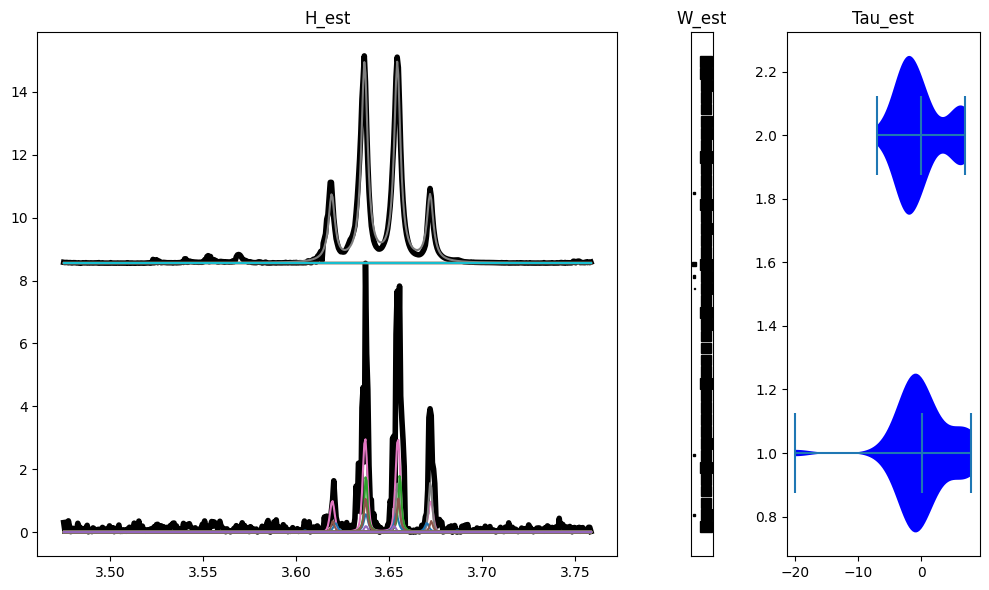

In [6]:
from helpers.plot import *
fig = plt.figure(figsize=(10, 6))
# Create a gridspec object with 2 rows and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

# Plot H and H_est
ax1 = plt.subplot(gs[0])
# plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
ax1.set_title('H_est')
x = np.arange(H_est.shape[1])

ax2 = plt.subplot(gs[1])
ax2.set_title('W_est')
hinton(W_est.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(tau_est, showmeans=True, showmedians=False, vert=False)
ax3.set_title('Tau_est')
change_violin_colors(violin_parts, color_list=['blue']*3)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# plt.figure(figsize=(15,5))
# plt.plot(H_est.T)
# plt.savefig("shiftcomponents")
# plt.clf()
ymax = 0
for i in range(len(H_est)):
    ymax = max(ymax,(H_est[i]/np.std(H_est[i])).max())
yoffset = ymax
reg_paths = []
lambda_axis = []
C_path = []
losses = []

for i in range(len(H_est)):
    means, sigmas, n = single_fit(H_est[i], min_height=0.1, min_sigma=1, lr=0.1 , plot=False)
    #diff_matrix = calc_difference_matrix(sigmas)
    diff_matrix = calc_difference_matrix(np.ones((len(sigmas))))
    hypothesis = peak_hypothesis(diff_matrix, cutoff=10/100)
    hardmodel = Hard_Model(H_est[i], hypothesis, means, sigmas, n)

    W, C, running_loss, path, lambdas, loss = hardmodel.fit(verbose=True, return_loss=True)
    reg_paths.append(path)
    lambda_axis.append(lambdas)
    C_path.append(C)
    losses.append(loss)
    means, sigma, j_coup, mult, n, w = hardmodel.return_values()
    print("means:")
    print(means)
    print("sigmas:")
    print(sigma)
    print("J coupling:")
    print(j_coup)
    print("multiplicity")
    print(mult)
    print("N")
    print(n)

    print("W:")
    print(W)
    ## TODO change this to be the true underlying components from H_ART not the shift found components, they need to be scaled accordingly.
    # plt.figure(figsize=(15,5))
    # plt.plot(H_est[i]/np.std(H_est[i]), linewidth=5, color="k")
    ax1.plot(ppm,H_est[i]/np.std(H_est[i])+yoffset*i, linewidth=4, color="k")
    for j, vec in enumerate(C):
        ax1.plot(ppm,vec*W[:,j]+yoffset*i)
# Set tight layout
plt.tight_layout()
plt.show()

In [8]:
print([ppm[int(i)] for i in means])
print([ppm[0] - ppm[int(i)] for i in j_coup])

[3.6453914018114766]
[0.017678467926085517]


[1.0, 0.5002478909116912, 0.4891044543725421, 0.4796102736317139, 0.45995595955124047, 0.40844608001052246, 0.36962492082509574, 0.366150311366648, 0.36348056383549665, 0.33713278977042016, 0.331143216998426, 0.32348814205160065, 0.31348882598147765, 0.3127027621463611, 0.3034547560901435, 0.3025733651323307, 0.30036845651786226, 0.29798605481683105, 0.2979720112635444, 0.2974873727050588, 0.2973365513726343, 0.2963952883937168, 0.2960733189911937, 0.29574968177065, 0.2955284300096157, 0.295280572999125, 0.29434577885066265, 0.29390451187453015, 0.2937140914616733, 0.2936697791989583, 0.29184852662052424, 0.2917376244300088, 0.29140435187134706, 0.2913893183711967, 0.29097771414588064, 0.2907933997983386, 0.29069568991815997, 0.2904700957613267, 0.2890523559435266, 0.2889626552451353, 0.2888917849414995, 0.2888665497785424, 0.28879443089558604, 0.2886894131023004, 0.2886051478826881, 0.28843778280431914, 0.2883677194470756, 0.28827637178444365, 0.2882685750134461, 0.28823206544795515, 

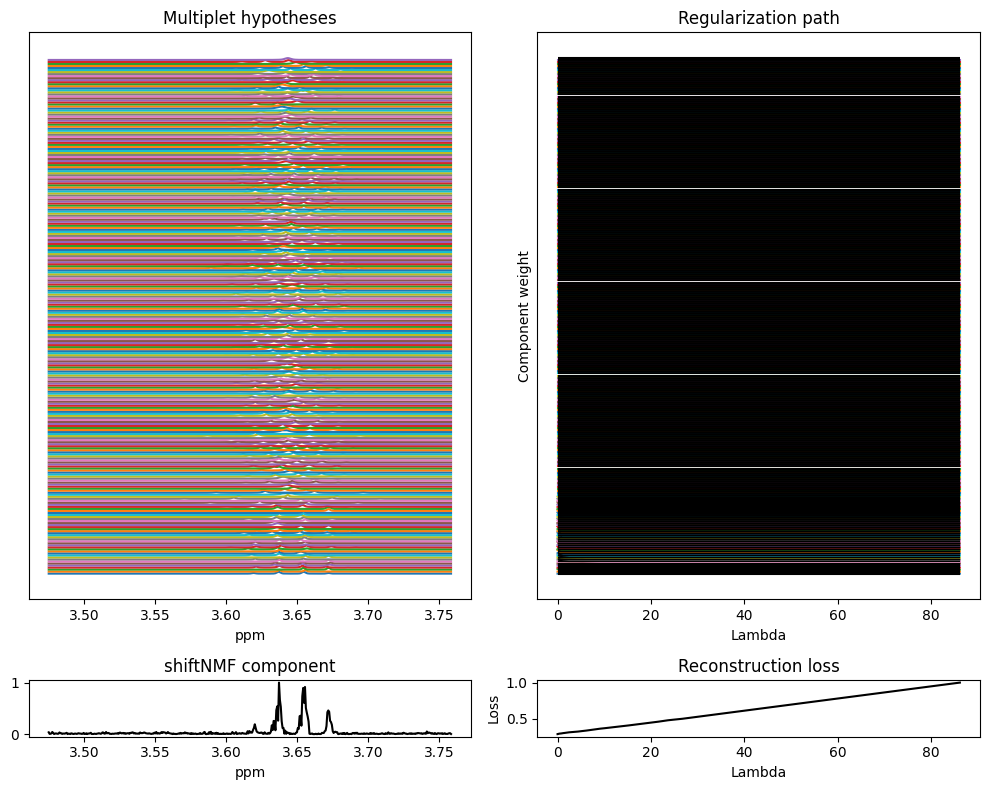

[1.0, 0.13831229593859684, 0.1372822706945313, 0.1328232434990598, 0.13119709064195068, 0.13058754777397652, 0.1303711779659112, 0.1290968729505113, 0.1288145594392211, 0.1286090765382546, 0.1273966628935348, 0.12725626051272868, 0.1272156875507086]
[12  8 10 13  0  6  5  3  2  1  4  7  9 11 14]


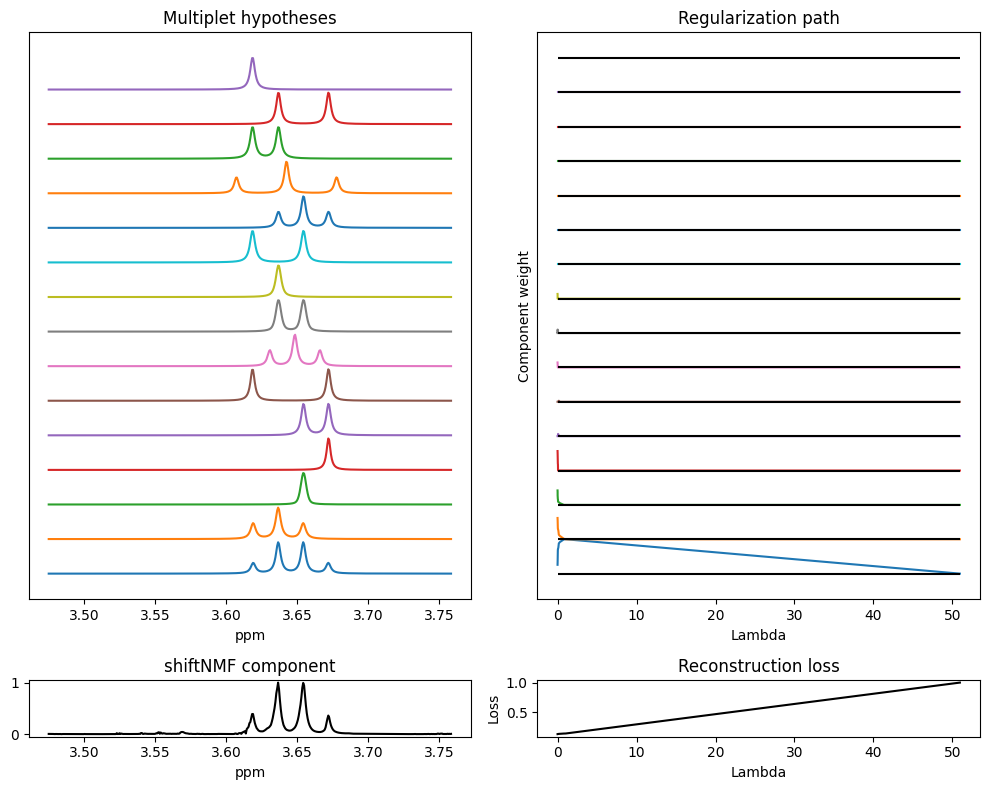

In [9]:

for i in range(len(reg_paths)):
    path = reg_paths[i][0]
    lambdas = lambda_axis[i][0]
    C = C_path[i]
    loss = losses[i]
    print(loss)
    fig = plt.figure(figsize=(10, 8))
    # Create a gridspec object with 2 rows and 3 columns
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[10,1])

    # Plot H and H_est
    ax1 = plt.subplot(gs[0])
    # plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
    ax1.set_title('Multiplet hypotheses')

    ax1.set_xlabel("ppm")
   
    x = np.arange(H_est.shape[1])

    ax2 = plt.subplot(gs[1])
    ax2.set_title('Regularization path')
    ax2.set_xlabel("Lambda")
    ax2.set_ylabel("Component weight")

    ax1.tick_params(left = False, labelleft = False)
    ax2.tick_params(left = False, labelleft = False)

    ax3 = plt.subplot(gs[2])
    # plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
    ax3.set_title('shiftNMF component')
    ax3.plot(ppm, H_est[i]/max(H_est[i]), color="k")
    ax3.set_xlabel("ppm")

    ax4 = plt.subplot(gs[3])
    # plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
    ax4.set_title('Reconstruction loss')
    ax4.plot(lambdas, loss, color="k")
    ax4.set_xlabel("Lambda")
    ax4.set_ylabel("Loss")

   
    sort_indices = np.argsort([np.trapz(p,lambdas) for p in path])
    print(sort_indices)
    path = path[sort_indices]
    C = C[sort_indices]

    ymax = 1.1
    yoffset = ymax
    t = 0

    nr_of_components = len(C)

    for j in range(nr_of_components):
            ax1.plot(ppm,C[j]/max(C[j])+yoffset*t)
            t += 1

    
    ymax = path.max()
    yoffset = ymax
    t = 0
    for j in range(nr_of_components):
            ax2.plot(lambdas,path[j]+yoffset*t)
            ax2.hlines(yoffset*t,lambdas[-1],lambdas[0], color="k")
            t +=1
    ax2.hlines(yoffset*t,lambdas[-1],lambdas[0], color="k")


    plt.tight_layout()
    plt.show()